In [1]:
# Import các thư viện cần thiết
import torch
import learn2learn as l2l
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Load dữ liệu
data = pd.read_csv("../../../Dataset/AKAM_Stock.csv")

In [3]:
data

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,3/1/2019,AKAM,71.089996,71.089996,71.489998,69.739998,70.059998,1633700
1,3/4/2019,AKAM,70.290001,70.290001,71.790001,69.709999,71.550003,995000
2,3/5/2019,AKAM,70.550003,70.550003,70.989998,69.800003,70.209999,1282100
3,3/6/2019,AKAM,71.540001,71.540001,71.680000,70.510002,70.620003,1658400
4,3/7/2019,AKAM,70.470001,70.470001,71.150002,70.019997,71.089996,1353400
...,...,...,...,...,...,...,...,...
1319,5/28/2024,AKAM,92.589996,92.589996,94.150002,92.489998,93.540001,1497900
1320,5/29/2024,AKAM,90.839996,90.839996,92.379997,90.779999,92.000000,1332200
1321,5/30/2024,AKAM,90.220001,90.220001,90.889999,89.550003,90.839996,2662200
1322,5/31/2024,AKAM,92.239998,92.239998,92.410004,89.599998,90.120003,3298500


In [4]:
data.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1.324000e+03
mean,98.894456,98.894456,99.920030,97.838044,98.871488,1.582324e+06
std,13.155544,13.155544,13.238076,13.092423,13.186564,9.565868e+05
min,69.120003,69.120003,69.260002,67.279999,68.230003,2.774000e+05
25%,88.715000,88.715000,89.742500,87.667500,88.660004,1.043800e+06
50%,100.404999,100.404999,101.779999,99.184998,100.419998,1.350500e+06
75%,110.002501,110.002501,111.330000,108.862501,109.972502,1.799050e+06
max,128.320007,128.320007,129.169998,126.980003,128.550003,1.077170e+07


In [5]:
# Check Null
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1324 non-null   object 
 1   Symbol     1324 non-null   object 
 2   Adj Close  1324 non-null   float64
 3   Close      1324 non-null   float64
 4   High       1324 non-null   float64
 5   Low        1324 non-null   float64
 6   Open       1324 non-null   float64
 7   Volume     1324 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 82.9+ KB


In [6]:
def detect_outlier(df, col):
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(df[(df[col] < lower_bound) | (df[col] > upper_bound)])

In [7]:
detect_outlier(data, 'Close')

Empty DataFrame
Columns: [Date, Symbol, Adj Close, Close, High, Low, Open, Volume]
Index: []


In [8]:
df=data.reset_index()['Close']

In [9]:
df

0       71.089996
1       70.290001
2       70.550003
3       71.540001
4       70.470001
          ...    
1319    92.589996
1320    90.839996
1321    90.220001
1322    92.239998
1323    90.900002
Name: Close, Length: 1324, dtype: float64

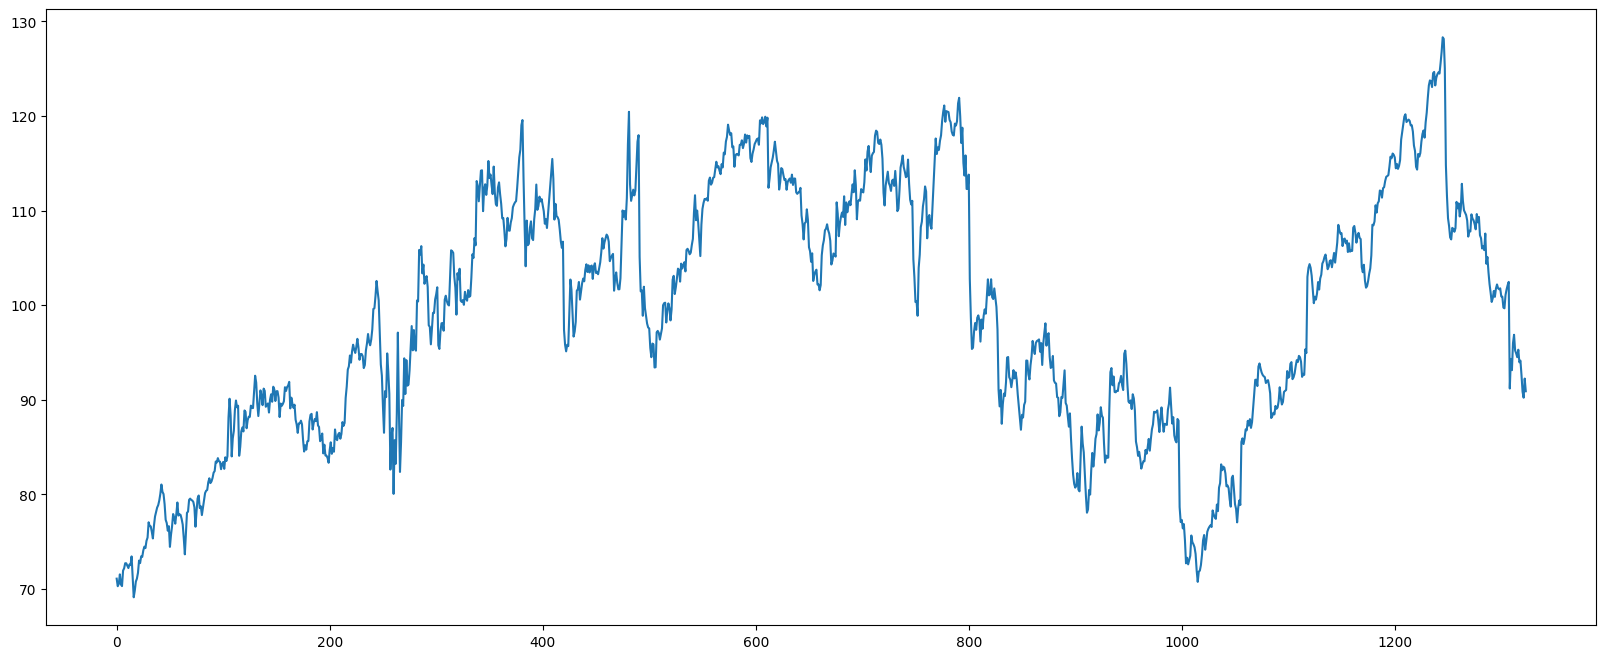

In [10]:
plt.figure(figsize=(20, 8))
plt.plot(df)
plt.show()

In [11]:
# Chuẩn hóa dữ liệu sử dụng MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

In [12]:
df

array([[0.03327692],
       [0.01976348],
       [0.02415541],
       ...,
       [0.35641887],
       [0.39054043],
       [0.36790536]])

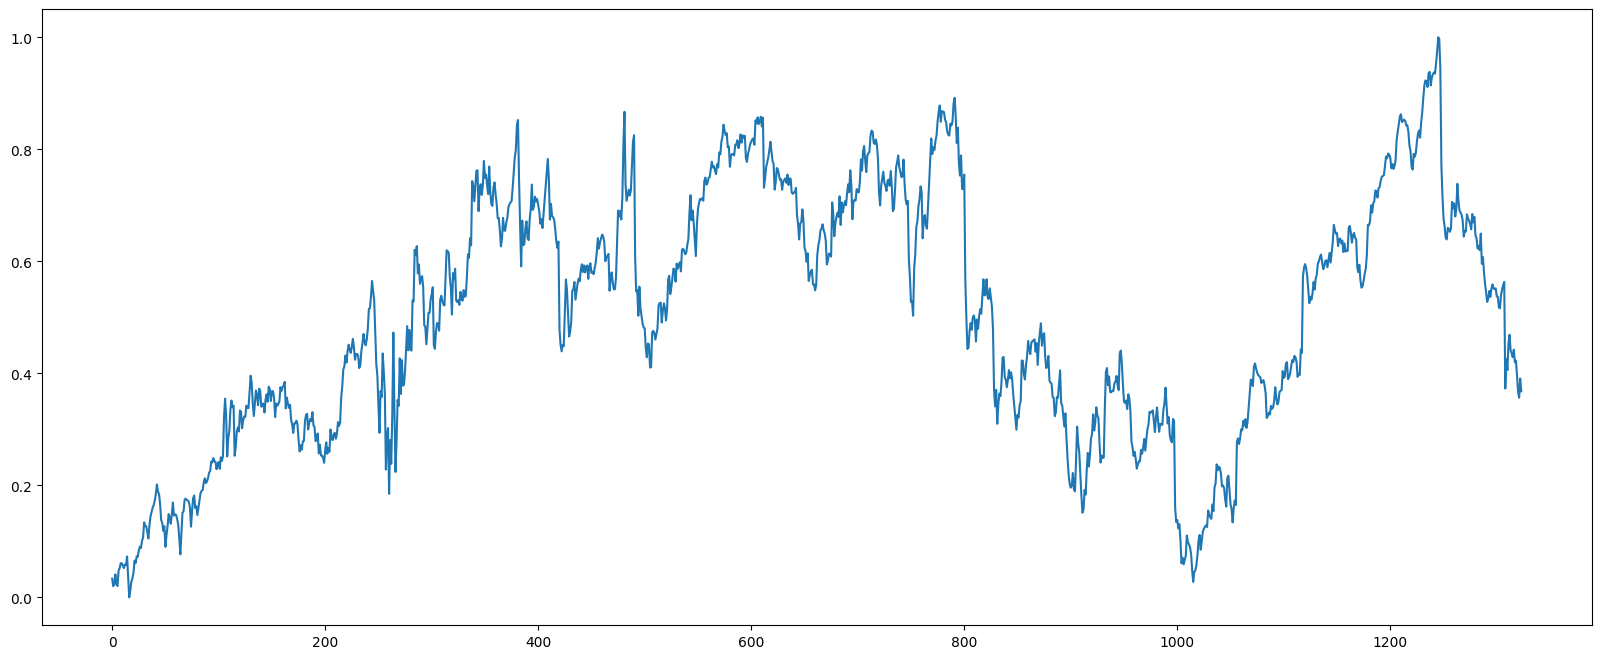

In [13]:
plt.figure(figsize=(20, 8))
plt.plot(df)
plt.show()

In [14]:
# Chia train test
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [15]:
# Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [16]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [17]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [18]:
# Tạo DataLoader
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(ytest))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [19]:
# Xây dựng mô hình
class StockPredictor(nn.Module):
    def __init__(self):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=24, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(24, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [20]:
# Định nghĩa hàm meta-learning
def fast_adapt(batch, learner, loss, adaptation_steps, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)
    for step in range(adaptation_steps):
        predictions = learner(data).view(-1)
        train_loss = loss(predictions, labels.view(-1))
        learner.adapt(train_loss)
    return train_loss

In [21]:
# Định nghĩa quá trình training
def meta_train(maml, train_loader, meta_optimizer, loss, adaptation_steps, meta_batch_size, device):
    for epoch in range(100):
        meta_loss = 0.0
        for batch in train_loader:
            learner = maml.clone()
            batch_loss = fast_adapt(batch, learner, loss, adaptation_steps, device)
            meta_loss += batch_loss.item()
            meta_optimizer.zero_grad()
            batch_loss.backward()
            # Ensure that only leaf tensors are used to calculate the gradients
            for param in maml.parameters():
                if param.grad is not None:
                    param.grad = param.grad.clone().detach()
            meta_optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {meta_loss/len(train_loader)}')

In [22]:
# Khởi tạo mô hình và các thành phần cần thiết
device = torch.device('cpu')
model = StockPredictor().to(device)
maml = l2l.algorithms.MAML(model, lr=0.01)
meta_optimizer = optim.Adam(maml.parameters(), lr=0.001)
loss = nn.MSELoss()

In [23]:
# Training mô hình
meta_train(maml, train_loader, meta_optimizer, loss, adaptation_steps=3, meta_batch_size=28, device=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:675: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


Epoch 1, Loss: 0.13268459389607112
Epoch 2, Loss: 0.048503730942805606
Epoch 3, Loss: 0.03865143097937107
Epoch 4, Loss: 0.03447292956213156
Epoch 5, Loss: 0.0279439444343249
Epoch 6, Loss: 0.013402483860651652
Epoch 7, Loss: 0.008169466288139422
Epoch 8, Loss: 0.006408936437219381
Epoch 9, Loss: 0.005591868950674931
Epoch 10, Loss: 0.005398926868413885
Epoch 11, Loss: 0.0051752071672429645
Epoch 12, Loss: 0.004967432717482249
Epoch 13, Loss: 0.004864443093538284
Epoch 14, Loss: 0.004827536037191748
Epoch 15, Loss: 0.004586815337340037
Epoch 16, Loss: 0.004388546897098422
Epoch 17, Loss: 0.004305873687068622
Epoch 18, Loss: 0.004216680272171895
Epoch 19, Loss: 0.0038182399856547516
Epoch 20, Loss: 0.0038462416268885136
Epoch 21, Loss: 0.003834213502705097
Epoch 22, Loss: 0.0037833920524766047
Epoch 23, Loss: 0.0038747438850502175
Epoch 24, Loss: 0.003520210754747192
Epoch 25, Loss: 0.0034754606274267036
Epoch 26, Loss: 0.003506763760621349
Epoch 27, Loss: 0.0032980176775405804
Epoch 28

In [24]:
# Dự đoán và hiển thị kết quả trên tập test
model.eval()
predictions = []
with torch.no_grad():
    for i in range(len(X_test)):
        x = torch.Tensor(X_test[i:i+1]).to(device)
        pred = model(x).cpu().numpy()
        predictions.append(pred)

predictions = np.array(predictions).flatten()
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

In [30]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#  Tính MAE
def calculate_mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

# Tính toán RMSE, MAPE và MDA
test_rmse = np.sqrt(np.mean((predictions - ytest) ** 2))
test_mape = calculate_mape(ytest, predictions)
test_mae = calculate_mae(ytest, predictions)

# In kết quả
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 11.56197549944488
Testing MAPE: 8.525032864214598
Testing MAE: 9.278813138379917


In [25]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_30 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 30):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_30.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_30_days = scaler.inverse_transform(np.array(lst_output_30).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 30 ngày tiếp theo:")
print(predicted_30_days)


Dự báo 30 ngày tiếp theo:
[[91.04399421]
 [90.9371554 ]
 [90.8487288 ]
 [90.75611024]
 [90.65201668]
 [90.53347352]
 [90.39992678]
 [90.25240679]
 [90.09284372]
 [89.92353466]
 [89.74679615]
 [89.56472592]
 [89.3791077 ]
 [89.19136526]
 [89.002596  ]
 [88.81360091]
 [88.62493398]
 [88.43698512]
 [88.24999957]
 [88.06415198]
 [87.87955882]
 [87.6963171 ]
 [87.51450623]
 [87.33421619]
 [87.15554577]
 [86.97860083]
 [86.80349958]
 [86.63036906]
 [86.45933981]
 [86.29054593]]


In [26]:
# Dự báo 60 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_60 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 60):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_60_days = scaler.inverse_transform(np.array(lst_output_60).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 60 ngày tiếp theo:")
print(predicted_60_days)


Dự báo 60 ngày tiếp theo:
[[91.04399421]
 [90.9371554 ]
 [90.8487288 ]
 [90.75611024]
 [90.65201668]
 [90.53347352]
 [90.39992678]
 [90.25240679]
 [90.09284372]
 [89.92353466]
 [89.74679615]
 [89.56472592]
 [89.3791077 ]
 [89.19136526]
 [89.002596  ]
 [88.81360091]
 [88.62493398]
 [88.43698512]
 [88.24999957]
 [88.06415198]
 [87.87955882]
 [87.6963171 ]
 [87.51450623]
 [87.33421619]
 [87.15554577]
 [86.97860083]
 [86.80349958]
 [86.63036906]
 [86.45933981]
 [86.29054593]
 [86.12412326]
 [85.9602059 ]
 [85.79892087]
 [85.64039343]
 [85.48473828]
 [85.33206302]
 [85.18246116]
 [85.03602799]
 [84.89283936]
 [84.75296408]
 [84.61646037]
 [84.48337411]
 [84.3537494 ]
 [84.22761271]
 [84.10498167]
 [83.98587217]
 [83.87028422]
 [83.75820897]
 [83.64963498]
 [83.54453842]
 [83.44289194]
 [83.3446629 ]
 [83.24980633]
 [83.15827368]
 [83.07001646]
 [82.9849782 ]
 [82.90309538]
 [82.82430626]
 [82.74854026]
 [82.67572682]]


In [27]:
# Dự báo 90 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])


lst_output_90 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 90):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_90_days = scaler.inverse_transform(np.array(lst_output_90).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 90 ngày tiếp theo:")
print(predicted_90_days)

Dự báo 90 ngày tiếp theo:
[[91.04399421]
 [90.9371554 ]
 [90.8487288 ]
 [90.75611024]
 [90.65201668]
 [90.53347352]
 [90.39992678]
 [90.25240679]
 [90.09284372]
 [89.92353466]
 [89.74679615]
 [89.56472592]
 [89.3791077 ]
 [89.19136526]
 [89.002596  ]
 [88.81360091]
 [88.62493398]
 [88.43698512]
 [88.24999957]
 [88.06415198]
 [87.87955882]
 [87.6963171 ]
 [87.51450623]
 [87.33421619]
 [87.15554577]
 [86.97860083]
 [86.80349958]
 [86.63036906]
 [86.45933981]
 [86.29054593]
 [86.12412326]
 [85.9602059 ]
 [85.79892087]
 [85.64039343]
 [85.48473828]
 [85.33206302]
 [85.18246116]
 [85.03602799]
 [84.89283936]
 [84.75296408]
 [84.61646037]
 [84.48337411]
 [84.3537494 ]
 [84.22761271]
 [84.10498167]
 [83.98587217]
 [83.87028422]
 [83.75820897]
 [83.64963498]
 [83.54453842]
 [83.44289194]
 [83.3446629 ]
 [83.24980633]
 [83.15827368]
 [83.07001646]
 [82.9849782 ]
 [82.90309538]
 [82.82430626]
 [82.74854026]
 [82.67572682]
 [82.60579535]
 [82.53866912]
 [82.47427137]
 [82.41252537]
 [82.35335435]

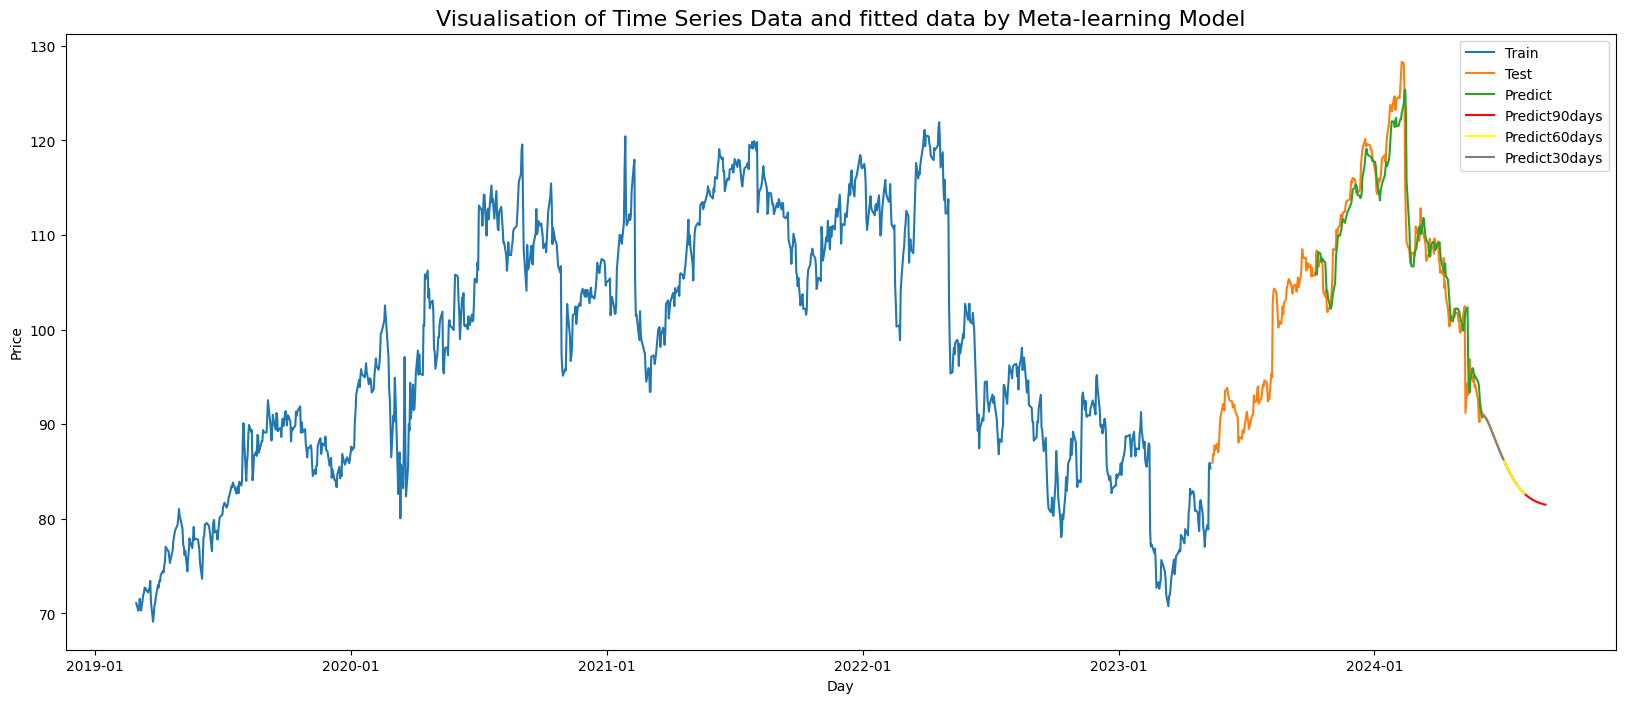

In [28]:
# 14.Vẽ hình
import matplotlib.dates as mdates
plt.figure(figsize=(20, 8))

data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'][:train_size],scaler.inverse_transform(train_data))
plt.plot(data['Date'][train_size:],scaler.inverse_transform(test_data))
plt.plot(data['Date'][train_size+101:],(predictions))

predict_data_index_90 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=90, freq='D')
predict_data_index_60 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=60, freq='D')
predict_data_index_30 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=30, freq='D')

plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Train','Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.title('Visualisation of Time Series Data and fitted data by Meta-learning Model' , fontsize=16)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

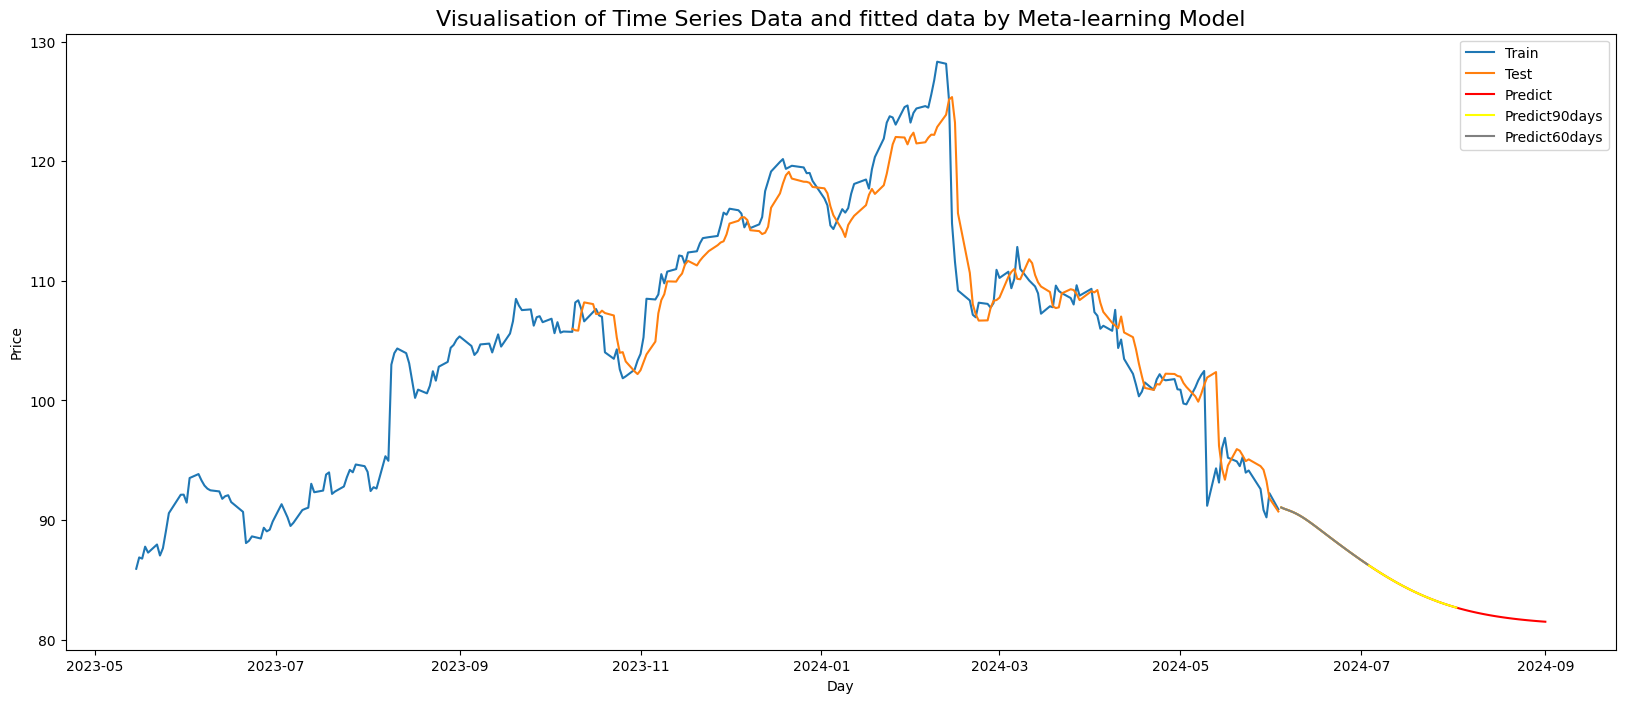

In [29]:
# 15.Vẽ hình test prediction
import matplotlib.dates as mdates
plt.figure(figsize=(20, 8))

data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'][train_size:],scaler.inverse_transform(test_data))
plt.plot(data['Date'][train_size+101:],(predictions))

predict_data_index_90 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=90, freq='D')
predict_data_index_60 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=60, freq='D')
predict_data_index_30 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=30, freq='D')

plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Train','Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.title('Visualisation of Time Series Data and fitted data by Meta-learning Model' , fontsize=16)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Predict90days', 'Predict60days', 'Predict30days'])
plt.title('Visualisation of predict 30, 60, 90 days data by Meta-learning Model' , fontsize=16)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()